In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../src"))
sys.path.append(os.path.abspath("../"))

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, 
                            recall_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            classification_report)
from sklearn.utils.class_weight import compute_class_weight
import joblib
import time
import json
from pathlib import Path
from config import PROCESSED_DATA_PATH
from utils import load_tiff_image,load_mask
from visualization import plot_image_and_mask

In [ ]:
OUTPUT_PATH = Path("../outputs")
MODEL_PATH = OUTPUT_PATH / "models"
os.makedirs(MODEL_PATH, exist_ok=True)

CLOUD_CATEGORIES = ['cloud_free', 'partially_clouded', 'fully_clouded']

# RF Model parameters
TEST_SIZE = 0.2
RF_PARAMS = {
    'n_estimators': 100,      # number of trees in the forest
    'max_depth': 15,          # less depth no overfitting
    'min_samples_split': 5,   # regularization
    'min_samples_leaf': 5,    # regularization
    'max_features': 'sqrt',   
    'random_state': 42,
    'n_jobs': -1,          # Use all cores (cook my CPU)
    'verbose': 0,          # debugging
    'class_weight': None   # i will handle it in the fit call
}

In [ ]:
def calculate_ndvi(image):
    red = image[:, :, 0].astype('float32')
    nir = image[:, :, 3].astype('float32')
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def calculate_ndwi(image):
    green = image[:, :, 1].astype('float32')
    nir = image[:, :, 3].astype('float32')
    ndwi = (green - nir) / (green + nir + 1e-6)
    return ndwi

def calculate_cloud_index(image):
    blue = image[:, :, 2].astype('float32')
    nir = image[:, :, 3].astype('float32')
    ci = (blue - nir) / (blue + nir + 1e-6)
    return ci

def calculate_ndsi(image):
    green = image[:, :, 1].astype('float32')
    nir = image[:, :, 3].astype('float32')
    return (green - nir) / (green + nir + 1e-6)

def extract_features(image):
    if image.shape == (512, 512,4):
        image = np.transpose(image, (2, 0, 1))  # Convert to (4, 512, 512)
    elif image.shape == (4, 512, 512):
        pass  # Already in correct format
    else:
        raise ValueError(f"Unexpected image shape: {image.shape}. Expected (4,512,512) or (512,512,4)")
    
    features = [
        image[:, :, 0].ravel(),     # Red
        image[:, :, 1].ravel(),     # Green
        image[:, :, 2].ravel(),     # Blue
        image[:, :, 3].ravel(),     # IR
        calculate_ndvi(image).ravel(),
        calculate_ndwi(image).ravel(),
        calculate_cloud_index(image).ravel(),
        calculate_ndsi(image).ravel()
    ]
    
    return np.column_stack(features) # [r,g,b,ir,ndvi,ndwi,ci,ndsi] for each pixel

In [ ]:
def prepare_datasets(base_path):
    image_mask_pairs = []
    
    for category in CLOUD_CATEGORIES:
        image_dir = base_path / "data" / category
        mask_dir = base_path / "masks" / category
        
        if not image_dir.exists() or not mask_dir.exists():
            print(f"Directory is Missing for category {category}")
            continue
            
        image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.tif')])
        
        for img, msk in zip(image_files, mask_files):
            image_mask_pairs.append((image_dir / img, mask_dir / msk, category))
    
    return image_mask_pairs

image_mask_pairs = prepare_datasets(PROCESSED_DATA_PATH)

In [ ]:
def preprocess_balanced_data(image_mask_pairs, samples_per_category=100000):
    X = []
    y = []
    categories = []
    
    # Group by category
    category_groups = {}
    for img_path, mask_path, category in image_mask_pairs:
        if category not in category_groups:
            category_groups[category] = []
        category_groups[category].append((img_path, mask_path))
    
    for category, pairs in category_groups.items():
        print(f"\nProcessing {len(pairs)} {category} images...")
        category_samples = 0
        
        for img_path, mask_path in tqdm(pairs):
            image = load_tiff_image(img_path)
            mask = load_mask(mask_path)
            
            image = image.astype('float32') / np.iinfo(image.dtype).max
            
            features = extract_features(image)
            labels = mask.ravel()
            
            # Max samples per category (it will kill my RAM if i load all the pixels)
            if samples_per_category:
                n_samples = min(samples_per_category - category_samples, features.shape[0])
                if n_samples <= 0:
                    continue
                    
                idx = np.random.choice(features.shape[0], n_samples, replace=False)
                features = features[idx]
                labels = labels[idx]
                category_samples += n_samples
            
            X.append(features)
            y.append(labels)
            categories.extend([category] * len(labels))
            
            if samples_per_category and category_samples >= samples_per_category:
                print(f"Reached max samples for {category}")
                break
    
    X = np.vstack(X) if len(X) > 1 else X[0]
    y = np.concatenate(y)
    categories = np.array(categories)
    
    return X, y, categories

# Balanced sampling
X, y, categories = preprocess_balanced_data(image_mask_pairs, samples_per_category=1000000)

print(f"\nTotal samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")
print("Class distribution:")
print(pd.Series(y).value_counts())
print("\nCategory distribution:")
print(pd.Series(categories).value_counts())

# Plot class distribution
plt.figure(figsize=(10,5))
plt.hist(y, bins=20)
plt.title('Pixel Class Distribution')
plt.xlabel('Class (0=No Cloud, 1=Cloud)')
plt.ylabel('Count')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test, cat_train, cat_test = train_test_split(
    X, y, categories, test_size=TEST_SIZE, 
    random_state=42, stratify=y)

print(f"Train shape: {X_train.shape} (categories: {np.unique(cat_train, return_counts=True)})")
print(f"Test shape: {X_test.shape} (categories: {np.unique(cat_test, return_counts=True)})")

In [ ]:
print("Training Random Forest classifier...")

# Category weighting
category_counts = pd.Series(cat_train).value_counts()
category_weights = (1 / (category_counts + 1e-6)) 
category_weights = category_weights / category_weights.sum()
category_weights = category_weights.to_dict()

# Pixel weighting
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

# Combine weights
sample_weights = np.ones_like(y_train, dtype='float32')
for idx, (category, label) in enumerate(zip(cat_train, y_train)):
    sample_weights[idx] = category_weights[category] * class_weight_dict[label]

print("\nWeight Statistics:")
print(f"Category weights: {category_weights}")
print(f"Class weights: {class_weight_dict}")
print(f"Sample weights - Min: {sample_weights.min():.4f}, Max: {sample_weights.max():.4f}")
print(f"Sample weights - Mean: {sample_weights.mean():.4f}, Std: {sample_weights.std():.4f}")

rf_model = RandomForestClassifier(**RF_PARAMS)

start_time = time.time()
rf_model.fit(X_train, y_train, sample_weight=sample_weights)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds")

In [ ]:
def evaluate_model(model, X, y, categories=None):
    start_time = time.time()
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    inference_time = time.time() - start_time
    
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, zero_division=0),
        'recall': recall_score(y, y_pred, zero_division=0),
        'f1': f1_score(y, y_pred, zero_division=0),
        'confusion_matrix': confusion_matrix(y, y_pred),
        'classification_report': classification_report(y, y_pred, target_names=['No Cloud', 'Cloud'])
    }
    
    if y_proba is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y, y_proba)
        except ValueError as e:
            print(f"ROC AUC skipped: {str(e)}")
            metrics['roc_auc'] = None
    
    category_results = []
    if categories is not None:
        for category in np.unique(categories):
            mask = categories == category
            y_true_sub = y[mask]
            
            # Skip free cloud categories because it has only single class (0 pixel)
            if len(y_true_sub) < 2 or len(np.unique(y_true_sub)) < 2:
                continue
                
            cat_metrics = {
                'category': category,
                'accuracy': accuracy_score(y_true_sub, y_pred[mask]),
                'precision': precision_score(y_true_sub, y_pred[mask], zero_division=0),
                'recall': recall_score(y_true_sub, y_pred[mask], zero_division=0),
                'f1': f1_score(y_true_sub, y_pred[mask], zero_division=0),
                'support': sum(mask)
            }
            
            if y_proba is not None:
                try:
                    cat_metrics['roc_auc'] = roc_auc_score(y_true_sub, y_proba[mask])
                except ValueError:
                    cat_metrics['roc_auc'] = None
                    
            category_results.append(cat_metrics)

    metrics.update({
        'inference_time': inference_time,
        'category_results': category_results
    })
    
    return metrics

test_metrics = evaluate_model(rf_model, X_test, y_test, cat_test)

print("\nTest Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"ROC AUC: {test_metrics['roc_auc']:.4f}")
print("\nConfusion Matrix:")
print(test_metrics['confusion_matrix'])
print("\nClassification Report:")
print(test_metrics['classification_report'])


In [ ]:
print("Feature importances:")
feature_names = ['Red', 'Green', 'Blue', 'IR', 'NDVI', 'NDWI', 'CloudIndex', 'NDSI']
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std': std})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print(feature_importance)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'], yerr=feature_importance['Std'])
plt.title("Feature Importances")
plt.ylabel("Mean Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Save model
model_filename = MODEL_PATH / "rf_model.pth"
joblib.dump(rf_model, model_filename)

# Logging
logs = {
    'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
    'model': 'RandomForest',
    'training_time_sec': training_time,
    'model_size_mb': Path(model_filename).stat().st_size/(1024*1024),
    'dataset_stats': {
        'total_samples': X.shape[0],
        'train_samples': X_train.shape[0],
        'test_samples': X_test.shape[0],
        'class_distribution': dict(zip(*np.unique(y, return_counts=True))),
        'category_distribution': dict(zip(*np.unique(categories, return_counts=True))),
    },
    'weights': {
        'category_weights': category_weights,
        'class_weights': class_weight_dict,
        'sample_weight_stats': {
            'min': float(sample_weights.min()),
            'max': float(sample_weights.max()),
            'mean': float(sample_weights.mean()),
            'std': float(sample_weights.std())
        }
    },
    'metrics': {
        'test': {k: v for k, v in test_metrics.items() 
                if k not in ['confusion_matrix', 'classification_report', 'category_results']}
    },
    'feature_importances': feature_importance.to_dict('records'),
    'parameters': RF_PARAMS,
    'inference_speed': {
        'pixels_per_sec': X_test.shape[0]/test_metrics['inference_time'],
        'time_per_pixel': test_metrics['inference_time']/X_test.shape[0]
    }
}

def convert_numpy_types(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    elif isinstance(obj, dict):
        return {str(k): convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_numpy_types(x) for x in obj]
    return obj

logs = convert_numpy_types(logs)

log_file = OUTPUT_PATH / "logs" / "rf_model_logs.json"
os.makedirs(log_file.parent, exist_ok=True)
with open(log_file, 'w') as f:
    json.dump(logs, f, indent=2)
    f.write("\n")

print(f"Model saved to {model_filename}")
print(f"Logs saved to {log_file}")

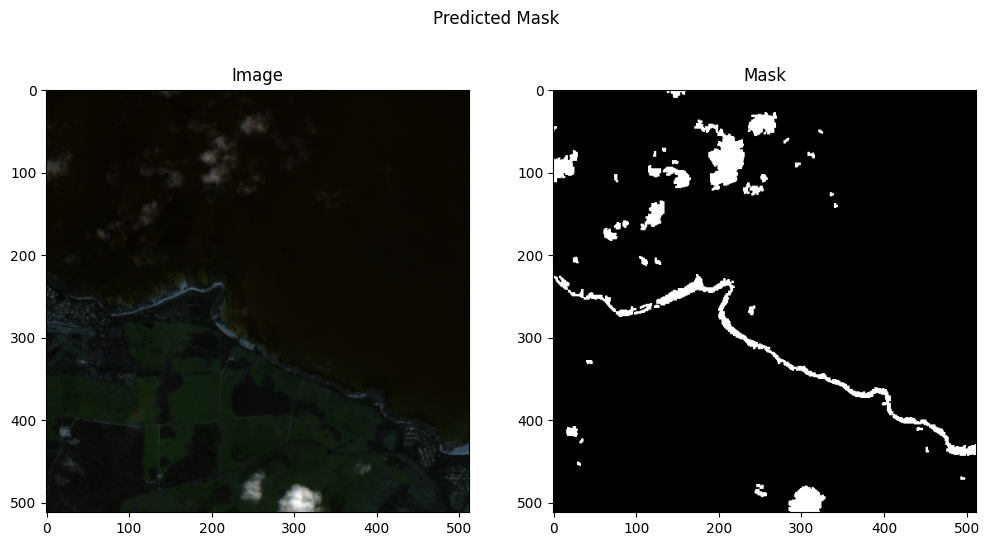

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Inference
def predict_full_image(model, image_path, output_path=None):
    image = load_tiff_image(image_path)
    
    if len(image.shape) == 3:
        if image.shape[0] == 4:  # (4, H, W)
            _, height, width = image.shape
        elif image.shape[2] == 4:  # (H, W, 4)
            height, width, channels = image.shape
            image = np.transpose(image, (2, 0, 1))
        else:
            raise ValueError(f"Expected 4 channels, got shape {image.shape}")
    else:
        raise ValueError(f"Expected 3D array, got shape {image.shape}")
    
    # Normalization
    image = image.astype('float32')
    for i in range(image.shape[0]):
        if np.max(image[i]) > 0:
            image[i] = image[i] / np.max(image[i])
    
    features = np.column_stack([
        # Original bands
        image[0].ravel(),  # R
        image[1].ravel(),  # G
        image[2].ravel(),  # B
        image[3].ravel(),  # IR
        ((image[3] - image[0]) / (image[3] + image[0] + 1e-6)).ravel(), # NDVI
        ((image[1] - image[3]) / (image[1] + image[3] + 1e-6)).ravel(), # NDWI
        ((image[2] - image[3]) / (image[2] + image[3] + 1e-6)).ravel(), # CI
        ((image[1] - image[3]) / (image[1] + image[3] + 1e-6)).ravel()  # NDSI
    ])
    
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(features)
        cloud_proba = proba[:, 1]
        proba_map = cloud_proba.reshape((height, width))
    else:
        mask_flat = model.predict(features)
        proba_map = mask_flat.reshape((height, width)).astype('float32')
    
    high_threshold = 0.75 
    low_threshold = 1  
    
    strong_clouds = proba_map > high_threshold
    weak_clouds = (proba_map > low_threshold) & (proba_map <= high_threshold)
    
    from scipy import ndimage
    
    # Small dilation on strong clouds
    struct = ndimage.generate_binary_structure(2, 2)
    dilated_strong = ndimage.binary_dilation(strong_clouds, structure=struct, iterations=1)
    
    # Connect weak clouds that are near strong clouds
    final_mask = dilated_strong.copy()
    
    # Add weak clouds that are connected to strong clouds
    labeled_weak, num_labels = ndimage.label(weak_clouds)
    if num_labels > 0:
        for label in range(1, num_labels + 1):
            if np.any(dilated_strong & (labeled_weak == label)):
                final_mask |= (labeled_weak == label)
    
    # Fill small holes in clouds
    final_mask = ndimage.binary_fill_holes(final_mask)
    
    # Remove small isolated cloud patches (smaller than 20 pixels)
    labeled_final, num_labels = ndimage.label(final_mask)
    component_sizes = np.bincount(labeled_final.ravel())
    small_components = component_sizes < 20
    small_components[0] = False
    remove_pixels = small_components[labeled_final]
    final_mask[remove_pixels] = False
    
    binary_mask = final_mask.astype(np.uint8)
    
    plot_image_and_mask(image, binary_mask, title="Predicted Mask", save_path=output_path)
    
    return binary_mask

# 289430
# 327408 Failed
# 130726
# 140804
# 262934
predict_full_image(rf_model, "test/data/289430.tif")